In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet(Path(r"/mnt/c/Finals/all_events.parquet"))
df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
df = df.dropna(subset=["ts", "src_ip", "pid"])
df = df.sort_values("ts")

In [3]:
df = df.sort_values(["src_ip", "ts"]).reset_index(drop=True)

In [4]:
df["hour_window"] = df["ts"].dt.floor("1H")
df["day"] = df["ts"].dt.date

def compute_entropy(values):
    if len(values) == 0:
        return 0.0
    value_counts = pd.Series(values).value_counts()
    probs = value_counts / len(value_counts)
    return -np.sum(probs * np.log2(probs + 1e-10))

def compute_hourly_features(group):
    if len(group) == 0:
        return pd.Series()
    
    group = group.sort_values("ts").reset_index(drop=True)
    
    failed = group[group["event_type"] == "failed_password"]
    accepted = group[group["event_type"].str.contains("accepted", case=False, na=False)]
    
    n_failed_password = len(failed)
    n_distinct_users = group["username"].nunique()
    accepted_sessions = len(accepted)
    
    total_attempts = n_failed_password + accepted_sessions
    success_ratio = accepted_sessions / total_attempts if total_attempts > 0 else 0.0
    
    num_failed_ports = failed["src_port"].nunique() if len(failed) > 0 else 0
    
    timestamps = group["ts"].values
    if len(timestamps) > 1:
        time_diffs = np.diff(timestamps.astype(np.int64) // 10**9)
        avg_time_between_attempts = np.mean(time_diffs) if len(time_diffs) > 0 else 0.0
        median_dt = np.median(time_diffs) if len(time_diffs) > 0 else 0.0
        login_interval_variance = np.var(time_diffs) if len(time_diffs) > 0 else 0.0
    else:
        avg_time_between_attempts = 0.0
        median_dt = 0.0
        login_interval_variance = 0.0
    
    time_of_day_seconds = timestamps.astype("datetime64[s]").astype(int) % 86400
    time_of_day_avg = np.mean(time_of_day_seconds) if len(time_of_day_seconds) > 0 else 0.0
    
    username_entropy = compute_entropy(group["username"].dropna().tolist())
    
    ip_entropy = 0.0
    
    duration = (timestamps[-1] - timestamps[0]).astype("timedelta64[s]").astype(float) if len(timestamps) > 1 else 0.0
    
    attempt_rate = n_failed_password / duration if duration > 0 else 0.0
    
    return pd.Series({
        "n_failed_password": n_failed_password,
        "n_distinct_users": n_distinct_users,
        "avg_time_between_attempts": avg_time_between_attempts,
        "num_failed_ports": num_failed_ports,
        "ip_entropy": ip_entropy,
        "success_ratio": success_ratio,
        "login_interval_variance": login_interval_variance,
        "username_entropy": username_entropy,
        "time_of_day_avg": time_of_day_avg,
        "accepted_sessions": accepted_sessions,
        "median_dt": median_dt,
        "duration": duration,
        "attempt_rate": attempt_rate,
        "first_ts": timestamps[0],
        "last_ts": timestamps[-1]
    })

print("Computing hourly features from events...")
agg = df.groupby(["src_ip", "hour_window"]).apply(compute_hourly_features).reset_index()

num_failed_days_by_ip = (
    df[df["event_type"] == "failed_password"]
    .groupby("src_ip")["day"]
    .nunique()
    .reset_index(name="num_failed_days")
)

agg = agg.merge(num_failed_days_by_ip, on="src_ip", how="left")
agg["num_failed_days"] = agg["num_failed_days"].fillna(0).astype(int)

agg["window_start"] = pd.to_datetime(agg["first_ts"])

for col in ["n_failed_password", "n_distinct_users", "avg_time_between_attempts", "num_failed_ports",
            "success_ratio", "login_interval_variance", "username_entropy", "time_of_day_avg",
            "num_failed_days", "accepted_sessions", "attempt_rate", "median_dt", "duration"]:
    if col in agg.columns:
        agg[col] = agg[col].fillna(0).astype(float)

print(f"Computed features for {len(agg):,} hourly windows")

Computing hourly features from events...
Computed features for 12,077 hourly windows


In [5]:
agg["ip_entropy"] = 0.0

In [6]:
agg["is_benign"] = (agg["accepted_sessions"] > 0).astype(int)
agg["is_attack"] = ((agg["accepted_sessions"] == 0) & 
                     ((agg["n_failed_password"] > 0) | (agg["n_distinct_users"] > 1))).astype(int)

X = agg.copy()
X = X.fillna(0)

paper_features = [
    "n_failed_password",
    "n_distinct_users",
    "avg_time_between_attempts",
    "num_failed_ports",
    "ip_entropy",
    "success_ratio",
    "login_interval_variance",
    "username_entropy",
    "time_of_day_avg",
    "num_failed_days"
]

X_benign = X[X["is_benign"] == 1].copy()
X_attack = X[X["is_attack"] == 1].copy()

In [7]:
scaler_attack = StandardScaler()

if len(X_attack) > 0:
    X_attack_scaled = scaler_attack.fit_transform(X_attack[paper_features])

In [8]:
agg["cluster"] = -1

if len(X_attack) > 0:
    eps_values = [0.2, 0.3, 0.4, 0.5]
    min_samples_values = [5, 7, 10, 15]
    
    best_score = -1
    best_params = None
    best_labels = None
    best_n_clusters = 0
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_attack_scaled)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = (labels == -1).sum()
            noise_ratio = n_noise / len(labels)
            
            if n_clusters >= 3 and noise_ratio < 0.5:
                mask = labels != -1
                if mask.sum() > 1:
                    score = silhouette_score(X_attack_scaled[mask], labels[mask])
                    if score > best_score:
                        best_score = score
                        best_params = (eps, min_samples)
                        best_labels = labels
                        best_n_clusters = n_clusters
    
    if best_labels is not None:
        attack_indices = X_attack.index
        for idx, label in zip(attack_indices, best_labels):
            agg.loc[idx, "cluster"] = label if label == -1 else label + 10
        
        print(f"Attack clusters - Best params: eps={best_params[0]}, min_samples={best_params[1]}")
        print(f"  Silhouette score: {best_score:.3f}")
        print(f"  Number of clusters: {best_n_clusters}")
        print(f"  Noise points: {(best_labels == -1).sum()} ({(best_labels == -1).mean()*100:.1f}%)")
    else:
        print("Warning: No suitable clustering found. Using default parameters.")
        dbscan = DBSCAN(eps=0.3, min_samples=10)
        best_labels = dbscan.fit_predict(X_attack_scaled)
        attack_indices = X_attack.index
        for idx, label in zip(attack_indices, best_labels):
            agg.loc[idx, "cluster"] = label if label == -1 else label + 10

if len(X_benign) > 0:
    benign_indices = X_benign.index
    agg.loc[benign_indices, "cluster"] = 0

print(f"\nCluster distribution:")
print(agg["cluster"].value_counts().sort_index())

Attack clusters - Best params: eps=0.4, min_samples=15
  Silhouette score: 0.455
  Number of clusters: 6
  Noise points: 719 (8.0%)

Cluster distribution:
cluster
-1     3704
 0      140
 10    7495
 11     359
 12     143
 13     104
 14     109
 15      23
Name: count, dtype: int64


In [9]:
original_features = ["n_failed_password", "median_dt", "duration", "n_distinct_users", "accepted_sessions", "is_attack"]
agg.groupby("cluster")[original_features].agg(["mean", "median", "std"]).round(2)

n_failed_password                median_dt                duration  \
                     mean median     std      mean median     std     mean   
cluster                                                                      
-1                  67.05    0.0  633.59    139.60    1.0  394.05   761.88   
 0                   0.18    0.0    0.51    132.16    0.0  380.17   228.71   
 10                 10.85    3.0   17.44      1.17    1.0    3.15   533.53   
 11                 10.07    4.0   10.52      2.32    2.0    1.68    87.28   
 12                  2.01    2.0    0.08      0.13    0.0    0.35  1526.83   
 13                  2.86    3.0    0.35      0.52    0.0    0.79  2791.25   
 14                430.55  439.0   22.68      1.83    2.0    0.38  3586.24   
 15                  2.17    2.0    0.39      1.78    2.0    0.47   889.65   

                         n_distinct_users                accepted_sessions  \
         median      std             mean median     std              mean   
cluster                                                                      
-1          6.0  1216.48            12.85    0.0  330.68              0.00   
 0          0.0   550.88             1.01    1.0    0.08              1.32   
 10        37.0   848.39             7.23    3.0    9.51              0.00   
 11        51.0   142.62             5.37    3.0    5.69              0.00   
 12      1521.0    26.28             1.38    1.0    0.50              0.00   
 13      3037.0   554.40             1.85    2.0    0.48              0.00   
 14      3590.0    40.59             1.00    1.0    0.00              0.00   
 15       796.0   268.26             2.04    2.0    0.37              0.00   

                    is_attack              
        median  std      mean median  std  
cluster                                    
-1         0.0  0.0      0.19    0.0  0.4  
 0         1.0  0.8      0.00    0.0  0.0  
 10        0.0  0.0      1.00    1.0  0.0  
 11        0.0  0.0      1.00    1.0  0.0  
 12        0.0  0.0      1.00    1.0  0.0  
 13        0.0  0.0      1.00    1.0  0.0  
 14        0.0  0.0      1.00    1.0  0.0  
 15        0.0  0.0      1.00    1.0  0.0

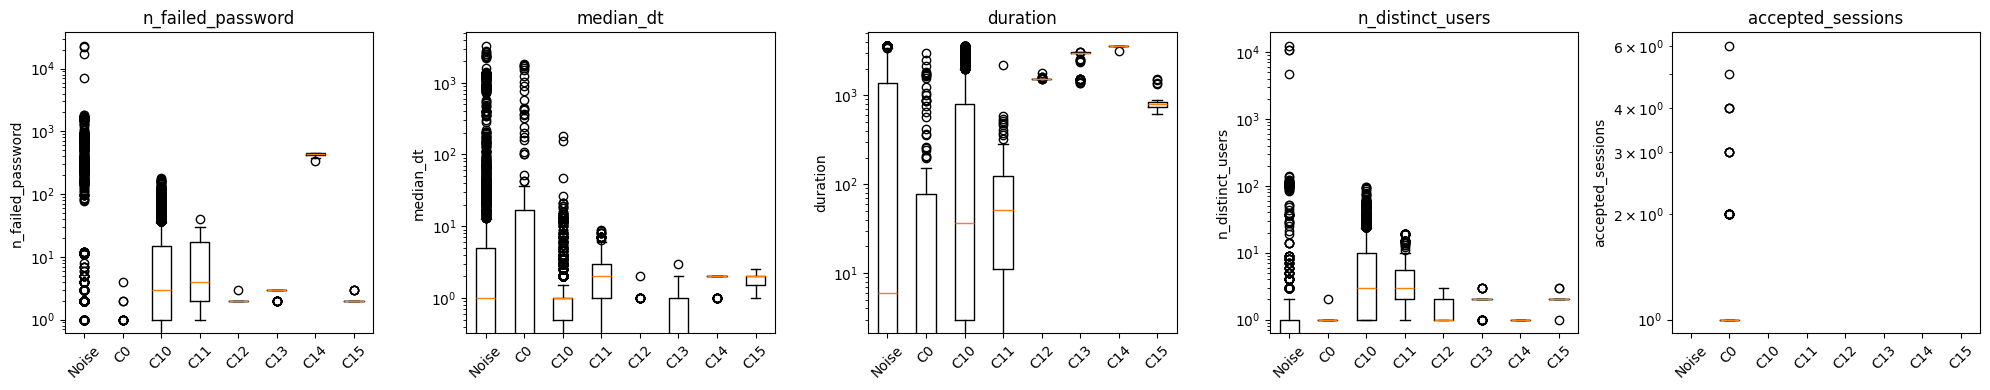

In [10]:
original_features = ["n_failed_password", "median_dt", "duration", "n_distinct_users", "accepted_sessions"]
fig, axes = plt.subplots(1, len(original_features), figsize=(20, 4))
for i, feature in enumerate(original_features):
    ax = axes[i]
    cluster_data_list = []
    cluster_labels = []
    for cluster in sorted(agg["cluster"].unique()):
        data = agg[agg["cluster"] == cluster][feature]
        if len(data) > 0:
            cluster_data_list.append(data.values)
            cluster_labels.append("Noise" if cluster == -1 else f"C{cluster}")
    if cluster_data_list:
        ax.boxplot(cluster_data_list, labels=cluster_labels)
    ax.set_ylabel(feature)
    ax.set_title(feature)
    ax.set_yscale("log")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [11]:
characterization_features = [
    "n_failed_password", "median_dt", "duration", "n_distinct_users", 
    "accepted_sessions", "attempt_rate", "avg_time_between_attempts",
    "num_failed_days", "login_interval_variance", "username_entropy"
]

summary = agg.groupby("cluster")[characterization_features].agg(["mean", "median"]).round(2)
summary["size"] = agg.groupby("cluster").size()

all_attack_data = agg[agg["is_attack"] == 1].copy()

def characterize_cluster(cluster_id, cluster_data, all_attack_data):
    if cluster_id == 0:
        accepted_val = cluster_data["accepted_sessions"].median()
        if accepted_val > 0:
            return "BENIGN", "Benign activity with successful logins"
        else:
            return "UNKNOWN", "Unclassified activity"
    elif cluster_id == -1:
        return "NOISE", "Noise/outliers - infrequent patterns"
    elif cluster_id >= 10:
        features = {}
        for feat in characterization_features:
            if feat in cluster_data.columns:
                features[feat] = cluster_data[feat].median()
        
        attempt_rate = features.get("attempt_rate", 0)
        median_dt = features.get("median_dt", 0)
        duration = features.get("duration", 0)
        num_failed_days = features.get("num_failed_days", 0)
        n_failed_password = features.get("n_failed_password", 0)
        n_distinct_users = features.get("n_distinct_users", 0)
        avg_time_between = features.get("avg_time_between_attempts", 0)
        
        attempt_rate_pct = (all_attack_data["attempt_rate"] <= attempt_rate).mean() * 100
        median_dt_pct = (all_attack_data["median_dt"] <= median_dt).mean() * 100
        duration_pct = (all_attack_data["duration"] <= duration).mean() * 100
        num_failed_days_pct = (all_attack_data["num_failed_days"] <= num_failed_days).mean() * 100
        
        if attempt_rate >= all_attack_data["attempt_rate"].quantile(0.75):
            freq_desc = "high-frequency"
        elif attempt_rate >= all_attack_data["attempt_rate"].quantile(0.50):
            freq_desc = "moderate-frequency"
        else:
            freq_desc = "low-frequency"
        
        if num_failed_days >= all_attack_data["num_failed_days"].quantile(0.75):
            persist_desc = "highly persistent"
        elif num_failed_days >= all_attack_data["num_failed_days"].quantile(0.50):
            persist_desc = "moderately persistent"
        else:
            persist_desc = "short-term"
        
        if median_dt >= all_attack_data["median_dt"].quantile(0.75):
            timing_desc = "long-interval"
        elif median_dt >= all_attack_data["median_dt"].quantile(0.50):
            timing_desc = "moderate-interval"
        else:
            timing_desc = "short-interval"
        
        if n_distinct_users >= 10:
            user_desc = "distributed"
        elif n_distinct_users >= 3:
            user_desc = "multi-user"
        else:
            user_desc = "focused"
        
        description = f"{freq_desc} {user_desc} attacks ({timing_desc} timing, {persist_desc} activity)"
        
        return f"CLUSTER_{cluster_id}", description
    else:
        return "UNKNOWN", "Unclassified"

cluster_characterizations = {}
for cluster_id in summary.index:
    cluster_data = agg[agg["cluster"] == cluster_id]
    cluster_type, description = characterize_cluster(cluster_id, cluster_data, all_attack_data)
    cluster_characterizations[cluster_id] = cluster_type
    summary.loc[cluster_id, "characterization"] = description

char_map = {}
for c in summary.index:
    if "characterization" in summary.columns:
        char_val = summary.loc[c, "characterization"]
        if isinstance(char_val, pd.Series):
            char_val = char_val.iloc[0] if len(char_val) > 0 else "Unclassified"
        char_map[c] = str(char_val) if pd.notna(char_val) else "Unclassified"
    else:
        char_map[c] = "Unclassified"

agg["characterization"] = agg["cluster"].map(char_map).fillna("Unclassified")

print("Cluster Characterizations:")
print("=" * 80)
for cluster_id in sorted(summary.index):
    size_val = int(summary.loc[cluster_id, "size"])
    char = summary.loc[cluster_id, "characterization"]
    print(f"Cluster {cluster_id:3d} (n={size_val:5d}): {char}")

print("\n" + "=" * 80)
print("\nCluster Summary Statistics:")
available_cols = [col for col in summary.columns if col == "size" or (isinstance(col, tuple) and col[1] == "median")]
if available_cols:
    print(summary[available_cols])
else:
    print(summary)

Cluster Characterizations:
Cluster  -1 (n= 3704):     Noise/outliers - infrequent patterns
Name: -1, dtype: object
Cluster   0 (n=  140):     Benign activity with successful logins
Name: 0, dtype: object
Cluster  10 (n= 7495):     low-frequency multi-user attacks (moderate-int...
Name: 10, dtype: object
Cluster  11 (n=  359):     moderate-frequency multi-user attacks (long-in...
Name: 11, dtype: object
Cluster  12 (n=  143):     low-frequency focused attacks (short-interval ...
Name: 12, dtype: object
Cluster  13 (n=  104):     low-frequency focused attacks (short-interval ...
Name: 13, dtype: object
Cluster  14 (n=  109):     moderate-frequency focused attacks (long-inter...
Name: 14, dtype: object
Cluster  15 (n=   23):     low-frequency focused attacks (long-interval t...
Name: 15, dtype: object


Cluster Summary Statistics:
        n_failed_password median_dt duration n_distinct_users  \
                   median    median   median           median   
cluster                       

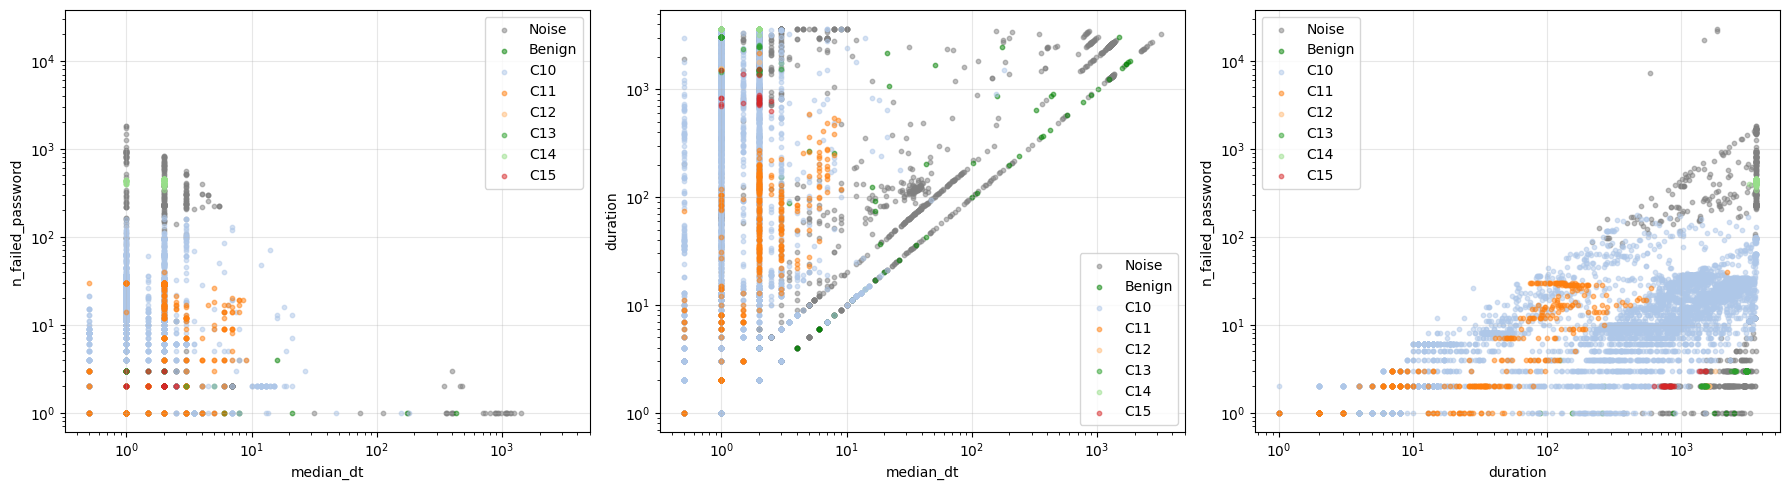

In [12]:
agg["cluster_label"] = agg["cluster"].apply(lambda x: f"C{x}" if x >= 0 else "Noise")

unique_clusters = sorted([c for c in agg["cluster"].unique() if c >= 0])
color_map = plt.cm.tab20
cluster_colors = {c: color_map(i % 20) for i, c in enumerate(unique_clusters)}
cluster_colors[-1] = "gray"
cluster_colors[0] = "green"

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_data = [
    ("median_dt", "n_failed_password", axes[0]),
    ("median_dt", "duration", axes[1]),
    ("duration", "n_failed_password", axes[2])
]

for x_feat, y_feat, ax in plot_data:
    for cluster_id in sorted(agg["cluster"].unique()):
        mask = agg["cluster"] == cluster_id
        if mask.sum() > 0:
            label = f"C{cluster_id}" if cluster_id >= 0 else "Noise"
            if cluster_id == 0:
                label = "Benign"
            ax.scatter(
                agg.loc[mask, x_feat],
                agg.loc[mask, y_feat],
                label=label,
                color=cluster_colors[cluster_id],
                alpha=0.5,
                s=10
            )
    ax.set_xlabel(x_feat)
    ax.set_ylabel(y_feat)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


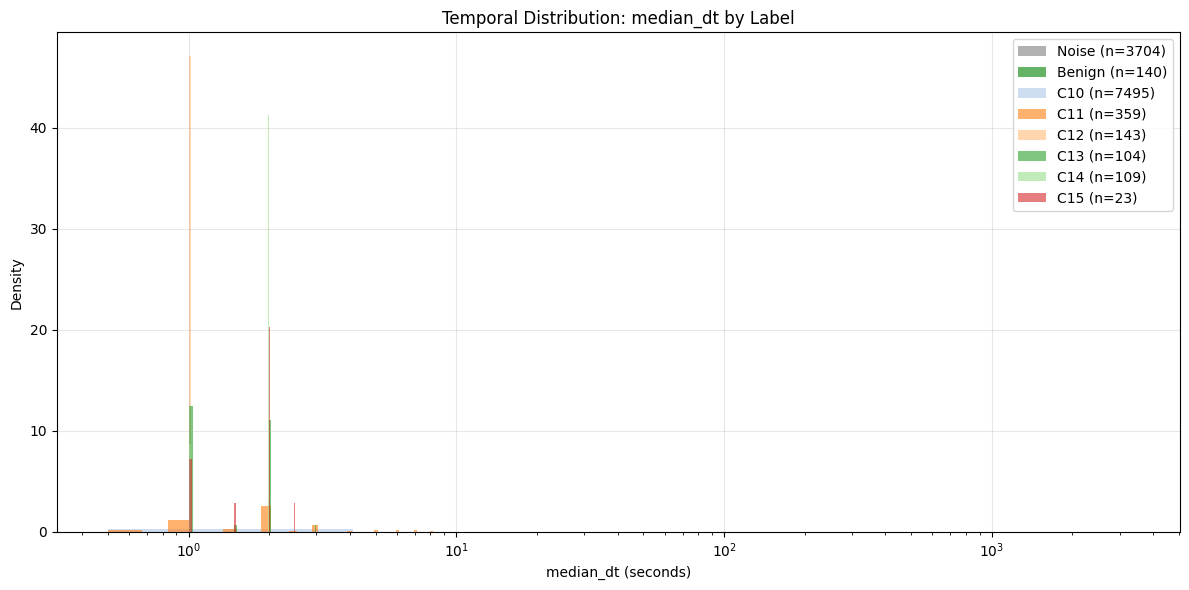

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

unique_clusters = sorted([c for c in agg["cluster"].unique() if c >= 0])
color_map = plt.cm.tab20
cluster_colors = {c: color_map(i % 20) for i, c in enumerate(unique_clusters)}
cluster_colors[-1] = "gray"
cluster_colors[0] = "green"

for cluster_id in sorted(agg["cluster"].unique()):
    mask = agg["cluster"] == cluster_id
    if mask.sum() > 0:
        data = agg.loc[mask, "median_dt"]
        data = data[data > 0]
        if len(data) > 0:
            label = f"C{cluster_id}" if cluster_id >= 0 else "Noise"
            if cluster_id == 0:
                label = "Benign"
            ax.hist(
                data,
                bins=50,
                alpha=0.6,
                label=f"{label} (n={mask.sum()})",
                color=cluster_colors[cluster_id],
                density=True
            )

ax.set_xlabel("median_dt (seconds)")
ax.set_ylabel("Density")
ax.set_xscale("log")
ax.set_title("Temporal Distribution: median_dt by Label")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

PCA Component Loadings:
  log_median_dt: PC1=-0.315, PC2=-0.527
  log_attempt_rate: PC1=0.093, PC2=0.732
  log_n_failed_password: PC1=0.658, PC2=-0.134
  log_n_distinct_users: PC1=0.658, PC2=-0.292
  accepted_sessions: PC1=-0.160, PC2=-0.291


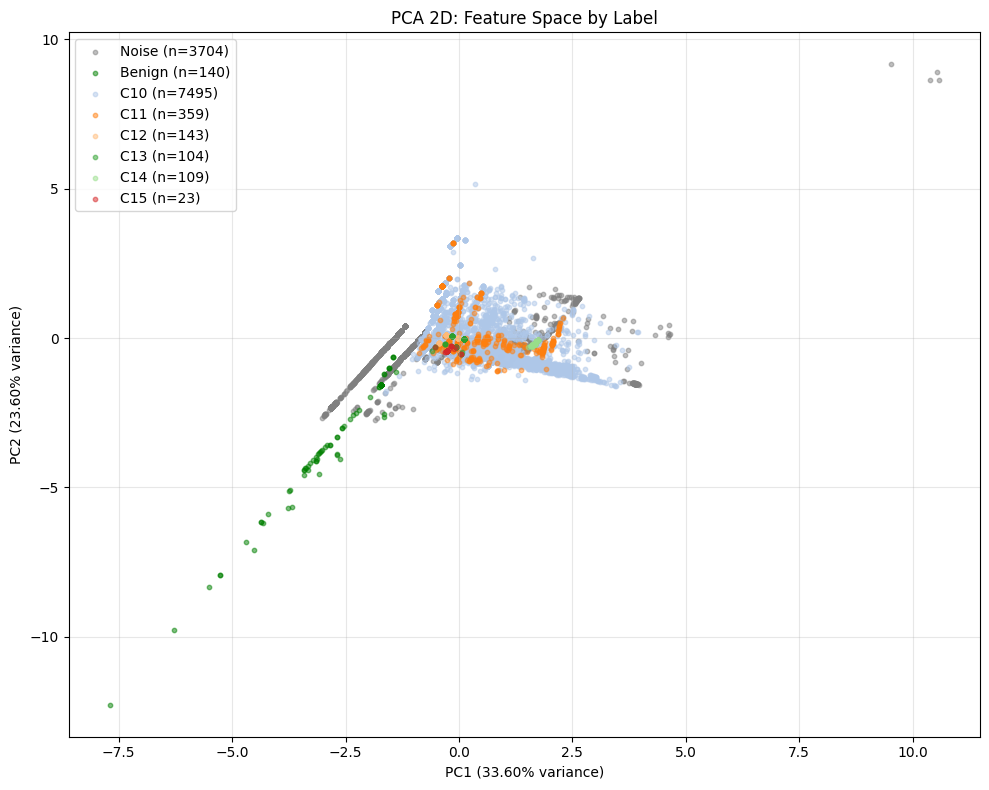

In [14]:

from sklearn.decomposition import PCA

pca_features = ["median_dt", "attempt_rate", "n_failed_password", "n_distinct_users", "accepted_sessions"]
X_pca = agg[pca_features].copy()
X_pca = X_pca.fillna(0)

for feat in ["median_dt", "attempt_rate", "n_failed_password", "n_distinct_users"]:
    X_pca[f"log_{feat}"] = np.log1p(X_pca[feat])

pca_feat_cols = ["log_median_dt", "log_attempt_rate", "log_n_failed_password", "log_n_distinct_users", "accepted_sessions"]
X_pca_scaled = StandardScaler().fit_transform(X_pca[pca_feat_cols])

pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_pca_scaled)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

unique_clusters = sorted([c for c in agg["cluster"].unique() if c >= 0])
color_map = plt.cm.tab20
cluster_colors = {c: color_map(i % 20) for i, c in enumerate(unique_clusters)}
cluster_colors[-1] = "gray"
cluster_colors[0] = "green"

for cluster_id in sorted(agg["cluster"].unique()):
    mask = agg["cluster"] == cluster_id
    if mask.sum() > 0:
        label = f"C{cluster_id}" if cluster_id >= 0 else "Noise"
        if cluster_id == 0:
            label = "Benign"
        ax.scatter(
            X_pca_2d[mask, 0],
            X_pca_2d[mask, 1],
            label=f"{label} (n={mask.sum()})",
            color=cluster_colors[cluster_id],
            alpha=0.5,
            s=10
        )

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
ax.set_title("PCA 2D: Feature Space by Label")
ax.legend()
ax.grid(True, alpha=0.3)

print("PCA Component Loadings:")
for i, (feat, loading1, loading2) in enumerate(zip(pca_feat_cols, pca.components_[0], pca.components_[1])):
    print(f"  {feat}: PC1={loading1:.3f}, PC2={loading2:.3f}")

plt.tight_layout()
plt.show()

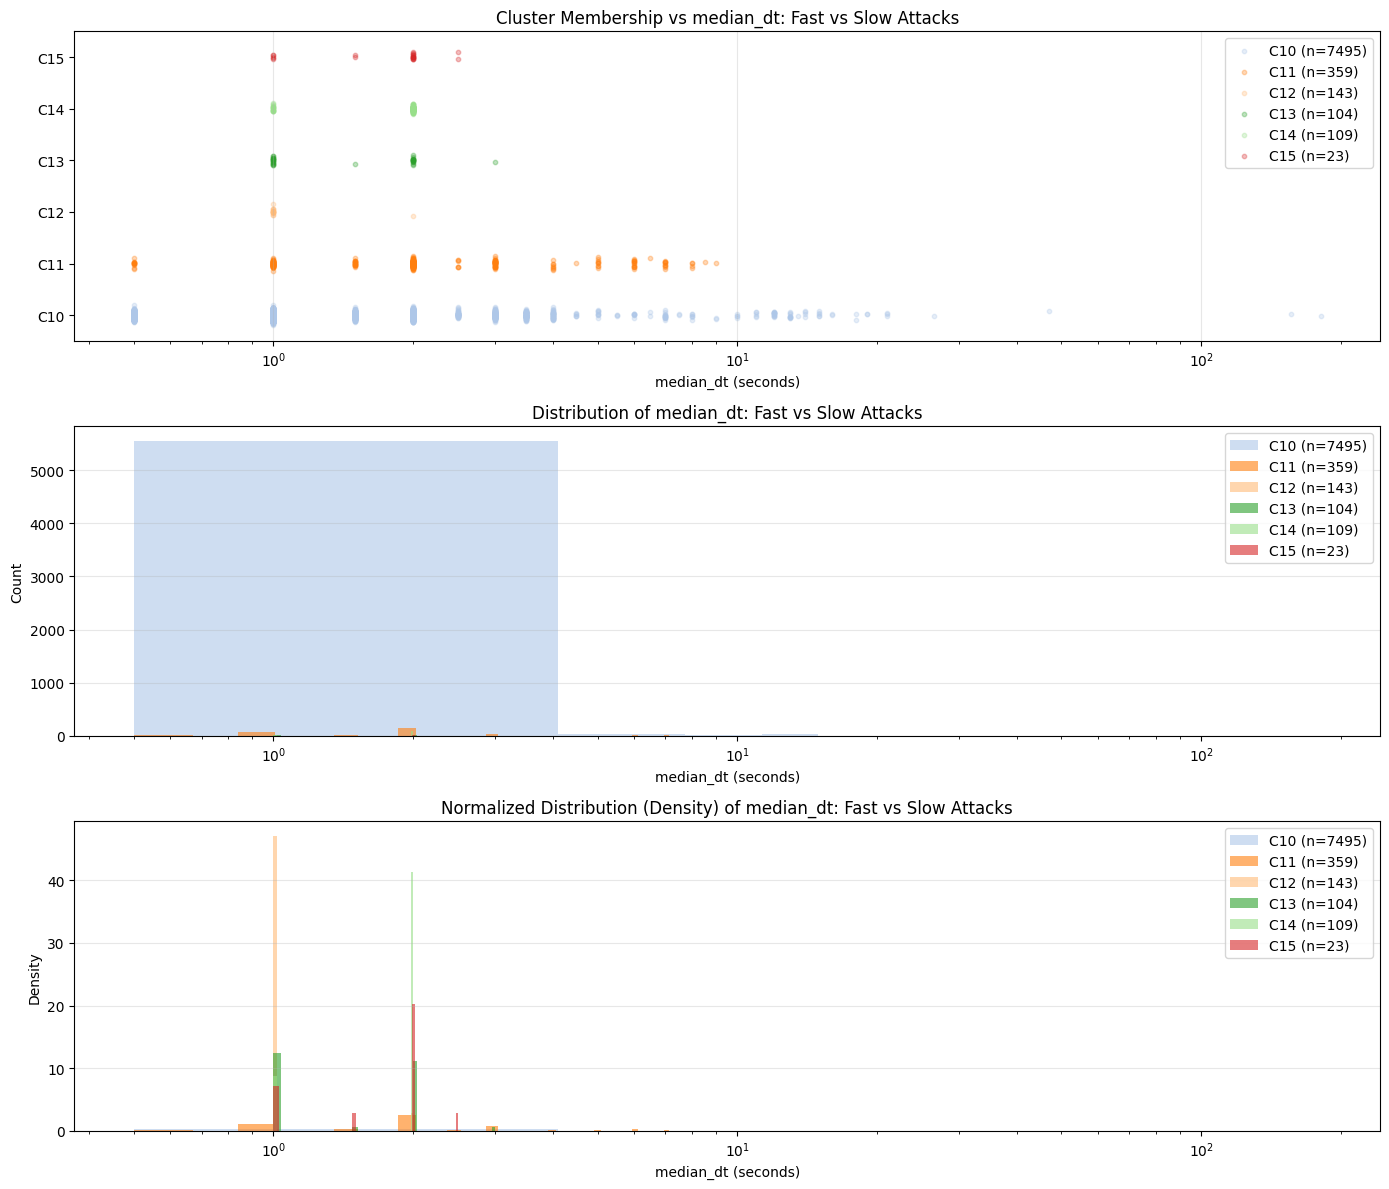

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

unique_clusters = sorted([c for c in agg["cluster"].unique() if c >= 0])
color_map = plt.cm.tab20
cluster_colors = {c: color_map(i % 20) for i, c in enumerate(unique_clusters)}
cluster_colors[-1] = "gray"
cluster_colors[0] = "green"

attack_clusters = [c for c in sorted(agg["cluster"].unique()) if c >= 10]
attack_data = agg[agg["cluster"].isin(attack_clusters)].copy()

y_positions = {c: i for i, c in enumerate(attack_clusters)}
for cluster_id in attack_clusters:
    mask = attack_data["cluster"] == cluster_id
    if mask.sum() > 0:
        data = attack_data.loc[mask, "median_dt"]
        data = data[data > 0]
        if len(data) > 0:
            y_pos = np.random.normal(y_positions[cluster_id], 0.05, len(data))
            axes[0].scatter(
                data.values,
                y_pos,
                alpha=0.3,
                s=10,
                color=cluster_colors[cluster_id],
                label=f"C{cluster_id} (n={mask.sum()})"
            )


axes[0].set_ylim(-0.5, len(attack_clusters) - 0.5)
axes[0].set_yticks(list(range(len(attack_clusters))))
axes[0].set_yticklabels([f"C{c}" for c in attack_clusters])
axes[0].set_xlabel("median_dt (seconds)")
axes[0].set_xscale("log")
axes[0].set_title("Cluster Membership vs median_dt: Fast vs Slow Attacks")
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

for cluster_id in attack_clusters:
    mask = attack_data["cluster"] == cluster_id
    if mask.sum() > 0:
        data = attack_data.loc[mask, "median_dt"]
        data = data[data > 0]
        if len(data) > 0:
            axes[1].hist(
                data.values,
                bins=50,
                alpha=0.6,
                label=f"C{cluster_id} (n={mask.sum()})",
                color=cluster_colors[cluster_id],
                density=False
            )


axes[1].set_xlabel("median_dt (seconds)")
axes[1].set_ylabel("Count")
axes[1].set_xscale("log")
axes[1].set_title("Distribution of median_dt: Fast vs Slow Attacks")
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

for cluster_id in attack_clusters:
    mask = attack_data["cluster"] == cluster_id
    if mask.sum() > 0:
        data = attack_data.loc[mask, "median_dt"]
        data = data[data > 0]
        if len(data) > 0:
            axes[2].hist(
                data.values,
                bins=50,
                alpha=0.6,
                label=f"C{cluster_id} (n={mask.sum()})",
                color=cluster_colors[cluster_id],
                density=True
            )


axes[2].set_xlabel("median_dt (seconds)")
axes[2].set_ylabel("Density")
axes[2].set_xscale("log")
axes[2].set_title("Normalized Distribution (Density) of median_dt: Fast vs Slow Attacks")
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')



plt.tight_layout()
plt.show()


In [16]:
agg["attack_type"] = agg["cluster"].map(cluster_characterizations).fillna("UNKNOWN")

type_map = {
    "BENIGN": "benign",
    "NOISE": "unknown",
    "UNKNOWN": "unknown"
}
for cluster_id in cluster_characterizations:
    if cluster_characterizations[cluster_id].startswith("CLUSTER_"):
        type_map[cluster_characterizations[cluster_id]] = f"cluster_{cluster_id}"

agg["attack_type"] = agg["attack_type"].map(type_map).fillna("unknown")

for col in ["characterization", "attack_type"]:
    if col in agg.columns:
        agg[col] = agg[col].astype(str)

output_path = Path("/mnt/c/Finals/all_events_clustered.parquet")
agg.to_parquet(output_path, index=False)
print(f"Exported clustered data to: {output_path}")
print(f"Total records: {len(agg)}")
print(f"\nFinal cluster distribution:")
print(agg["attack_type"].value_counts().sort_index())
print(f"\nCluster characterizations saved in 'characterization' column")


Exported clustered data to: /mnt/c/Finals/all_events_clustered.parquet
Total records: 12077

Final cluster distribution:
attack_type
benign         140
cluster_10    7495
cluster_11     359
cluster_12     143
cluster_13     104
cluster_14     109
cluster_15      23
unknown       3704
Name: count, dtype: int64

Cluster characterizations saved in 'characterization' column
